## 2. Weather model

In this exercise, you'll work with the historical temperature data from the previous checkpoint. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

    1) First, load the dataset from the weatherinszeged table from Thinkful's database.

    2) Build a linear regression model where your target variable is the difference between the apparenttemperature       and the temperature. 
        - As explanatory variables, use humidity and windspeed. 
        - Now, estimate your model using OLS. 
        - Are the estimated coefficients statistically significant? 
        - Are the signs of the estimated coefficients in line with your previous expectations? 
        - Interpret the estimated coefficients. What are the relations between the target and the explanatory                   variables?

    3) Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS.           - Are the coefficients statistically significant? 
        - Did the signs of the estimated coefficients for humidity and windspeed change? Interpret the estimated               coefficients.

Here are the credentials you can use to connect to the database:

    postgres_user = 'dsbc_student'
    postgres_pw = '7*.8G9QH21'
    postgres_host = '142.93.121.174'
    postgres_port = '5432'
    postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


### 1) Explore and clean the data

In [2]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [3]:
#Checked for NaN values and didn't find any.  The describe function shows that there may not be appearance of outliers
#Drop columns we will not use
weather_df.drop(columns=['date', 'summary','preciptype','dailysummary','visibility','loudcover'], axis=1, inplace=True)
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,1003.236
std,9.552,10.697,0.195,6.914,107.383,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,1046.380


In [4]:
#Handle outliers

import scipy.stats as stats
from scipy.stats.mstats import winsorize

def using_mstats(s):
    return winsorize(s, limits=[0.05, 0.05])

weather_clean = weather_df.apply(using_mstats, axis=0)
weather_clean.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

,temperature,apparenttemperature,humidity,windspeed,windbearing,pressure
0.000,-2.767,-6.044,0.350,2.528,10.000,1003.200
0.050,-2.767,-6.041,0.350,2.528,10.000,1003.200
0.250,4.689,2.311,0.600,5.828,116.000,1011.900
0.500,12.000,12.000,0.780,9.966,180.000,1016.450
0.750,18.839,18.839,0.890,14.136,290.000,1021.090
0.950,27.778,27.933,0.970,24.430,341.000,1030.190
1.000,27.778,27.933,0.970,24.440,341.000,1030.190


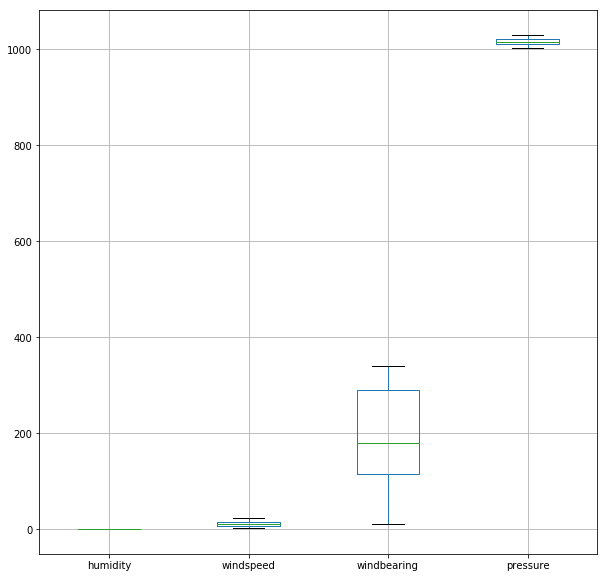

In [19]:
#Visual check for outliers on the key features for model

plt.figure(figsize=(10,10))

boxplot=weather_clean.boxplot(column=['humidity', 'windspeed', 'windbearing', 'pressure'])

### 2) Build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. 
    - As explanatory variables, use humidity and windspeed. 
    - Now, estimate your model using OLS. 
    - Are the estimated coefficients statistically significant? 
    - Are the signs of the estimated coefficients in line with your previous expectations? 
    - Interpret the estimated coefficients. What are the relations between the target and the explanatory                   variables?

In [24]:
#Create target variable
weather_clean['temp_delta']=weather_clean['temperature'] - weather_clean['apparenttemperature']
weather_clean.head()

,temperature,apparenttemperature,humidity,windspeed,windbearing,pressure,temp_delta
0,9.472,7.389,0.890,14.120,251.000,1015.130,2.083
1,9.356,7.228,0.860,14.265,259.000,1015.630,2.128
2,9.378,9.378,0.890,3.928,204.000,1015.940,0.000
3,8.289,5.944,0.830,14.104,269.000,1016.410,2.344
4,8.756,6.978,0.830,11.045,259.000,1016.510,1.778


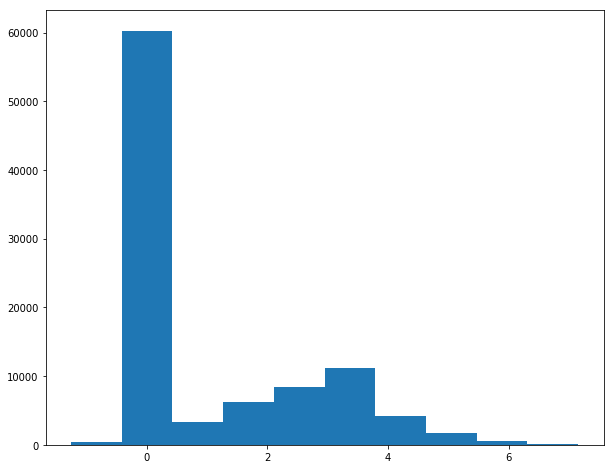

In [25]:
#Check distribution of target variable 'temperature'

plt.figure(figsize=(10,8))

#weather_clean['temperature'].plot.barh(alpha=0.5)

plt.hist(weather_clean['temp_delta'])
plt.show()

In [26]:
#Build the linear regression model
import statsmodels.api as sm

# Y is the target variable
Y = weather_clean['temp_delta']
# X is the feature set: 'humidity', 'windspeed', 'windbearing', 'pressure'
X = weather_clean[['humidity', 'windspeed']]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             temp_delta   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                 2.112e+04
Date:                Sat, 31 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:02:36   Log-Likelihood:            -1.6135e+05
No. Observations:               96453   AIC:                         3.227e+05
Df Residuals:                   96450   BIC:                         3.227e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7420      0.020   -135.588      0.000      -2.782      -2.702
humidity       3.4254      0.023    150.972      0.000       3.381       3.470
windspeed      0.1189      0.001    170.832      0.000       0.118       0.120
==============================================================================
Omnibus:                     2844.418   Durbin-Watson:                   0.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2430.311
Skew:                           0.324   Prob(JB):                         0.00
Kurtosis:                       2.569   Cond. No.                         88.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 The estimated coefficeints are statisically significant as their P values are 0.00.  
 
 - Every 3.4 increase in humidty will increase the delta between temperature and apparent temperature.  
 - Every .1189 knot change in windspeed will increase the delta between temperature and apparent temperatue.
 
 The signs of the coeeficients make sense (I would translate this into 'heat index' which is the difference between the actual temperature and 'what it feels like'.  Humidty has more an impact on making things 'feel' hotter. 

### 3) Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS.           

    - Are the coefficients statistically significant? 
    - Did the signs of the estimated coefficients for humidity and windspeed change? Interpret the estimated               coefficients.

In [29]:
#Create the interaction of humidty and windspeed
weather_clean['humidity_wind'] = weather_clean['humidity'] * weather_clean['windspeed']

In [30]:
#Build the linear regression model

# Y is the target variable
Y = weather_clean['temp_delta']
# X is the feature set: 'humidity', 'windspeed', 'windbearing', 'pressure'
X = weather_clean[['humidity', 'windspeed', 'humidity_wind']]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             temp_delta   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                 1.728e+04
Date:                Sat, 31 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:10:46   Log-Likelihood:            -1.5812e+05
No. Observations:               96453   AIC:                         3.163e+05
Df Residuals:                   96449   BIC:                         3.163e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4164      0.035    -12.056      0.000      -0.484      -0.349
humidity          0.2883      0.044      6.520      0.000       0.202       0.375
windspeed        -0.0916      0.003    -34.394      0.000      -0.097      -0.086
humidity_wind     0.2940      0.004     81.706      0.000       0.287       0.301
==============================================================================
Omnibus:                     1718.712   Durbin-Watson:                   0.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2032.635
Skew:                           0.273   Prob(JB):                         0.00
Kurtosis:                       3.455   Cond. No.                         209.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results of the new model are still statistically significant.  However the coefficients changed, especially for windpseed. 

Now the impact of the humidity coefficient dropped so as to have a more muted affect on the delta in temp/apparent temp.  Windspeed is now at -.09 versus .11 which makes sense given the new feature of humidity + windspeed.  This new feature has a bigger impact on the difference between temp and apparent temperature than the other two features both in this model and the previous model.  So humidity * windspeed contributes the most to the delta of temp and apparent temperature. 